In [2]:
import os
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
from scipy.signal import hilbert
from tqdm import tqdm
import matplotlib.pyplot as plt
import pywt

### 1. Reading data

#### Lunar data

In [3]:
lunar_cat_directory = 'space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
lunar_data_directory = 'space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
lunar_cat_file = lunar_cat_directory + 'apollo12_catalog_GradeA_final.csv'
lunar_cat = pd.read_csv(lunar_cat_file)
lunar_cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [4]:
# Lunar raw data

In [5]:
lunar_cat_dict = lunar_cat.to_dict(orient='records')
lunar_data = []
lunar_data_missing = []

for row in tqdm(lunar_cat_dict):
    data = {}
    data['arrival_time'] = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    data['arrival_time_rel'] = row['time_rel(sec)']
    data['filename'] = row['filename']
    csv_file = f'{lunar_data_directory}{data["filename"]}.csv'
    mseed_file = f'{lunar_data_directory}{data["filename"]}.mseed'
    try:
        st = read(mseed_file)
        data['sampling_rate'] = st[0].stats.sampling_rate
        data['raw'] = pd.read_csv(csv_file)
        lunar_data.append(data)
    except:
        lunar_data_missing.append(data['filename'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:19<00:00,  3.82it/s]


In [6]:
print(f'Total: {len(lunar_cat_dict)}, Valid: {len(lunar_data)}, Missing: {len(lunar_data_missing)}')

Total: 76, Valid: 75, Missing: 1


#### Mars data

In [7]:
mars_cat_directory = 'space_apps_2024_seismic_detection/data/mars/training/catalogs/'
mars_data_directory = 'space_apps_2024_seismic_detection/data/mars/training/data/'
mars_cat_file = mars_cat_directory + 'Mars_InSight_training_catalog_final.csv'
mars_cat = pd.read_csv(mars_cat_file)
mars_cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:08:27.000000,507.0,evid0005
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,2022-01-02T04:35:30.000000,2130.0,evid0006


In [8]:
# Mars raw data

In [9]:
mars_cat_dict = mars_cat.to_dict(orient='records')
mars_data = []
mars_data_missing = []

for row in tqdm(mars_cat_dict):
    data = {}
    data['arrival_time'] = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
    data['arrival_time_rel'] = row['time_rel(sec)']
    data['filename'] = row['filename']
    csv_file = f'{mars_data_directory}{data["filename"]}'
    mseed_file = f'{mars_data_directory}{".".join(data["filename"].split(".")[:-1])}.mseed'
    st = read(mseed_file)
    data['sampling_rate'] = st[0].stats.sampling_rate
    try:
        data['raw'] = pd.read_csv(csv_file)
        mars_data.append(data)
    except:
        mars_data_missing.append(data['filename'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.66it/s]


In [10]:
print(f'Total: {len(mars_cat_dict)}, Valid: {len(mars_data)}, Missing: {len(mars_data_missing)}')

Total: 2, Valid: 2, Missing: 0


### 2. Filtering

#### Helpers

In [11]:
from scipy.signal import butter, filtfilt

In [12]:
def apply_adaptive_high_pass_filter(velocities, fs, rms_noise_level, noise_multiplier=1.5, order=1):
    """
    Applies an adaptive high-pass filter to the velocities data based on the RMS noise level.
    
    Parameters:
    velocities : array-like
        The velocity data to be filtered.
    fs : float
        The sampling rate of the data (in Hz).
    rms_noise_level : float
        The RMS noise level, calculated using the calculate_rms_noise_level function.
    noise_multiplier : float
        The factor to adjust the cutoff frequency based on the RMS noise level (default is 1.5).
    order : int
        The order of the filter.

    Returns:
    filtered_velocities : array-like
        The filtered velocity data.
    """
    # Estimate a cutoff frequency based on RMS noise level
    # This assumes that higher noise levels correspond to higher frequencies in the noise
    cutoff_frequency = rms_noise_level * noise_multiplier  # Scale the RMS noise level to determine cutoff

    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff_frequency / nyquist  # Normalize the cutoff frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)

    # Apply the filter to the velocities using filtfilt for zero-phase filtering
    filtered_velocities = filtfilt(b, a, velocities)
    
    return filtered_velocities

In [13]:
def apply_wavelet_filter(velocities, wavelet='haar', level=6, mode='soft'):
    """
    Applies wavelet denoising to the velocities data.
    Wavelet filtering allows to decompose the signal into multiple levels of frequency bands (scales). 
    By applying a threshold to the wavelet coefficients, you can filter out noise at specific frequency levels, 
    while preserving the seismic event's structure across both time and frequency domains.
    
    Parameters:
    velocities : array-like
        The velocity data to be filtered.
    wavelet : str
        The type of wavelet to use (default is 'db4', Daubechies wavelet). 
        Daubechies wavelets are often used for seismic data as they are well-suited for capturing non-stationary features.
    level : int, optional
        The level of decomposition. If None, the maximum level is used.
    mode : str
        The thresholding mode. 'soft' for soft thresholding, 'hard' for hard thresholding.

    Returns:
    denoised_velocities : array-like
        The denoised velocity data.
    """
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(velocities, wavelet, level=level)

    # Set the universal threshold (Donoho's method)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(velocities)))

    # Apply thresholding to the wavelet coefficients
    denoised_coeffs = [pywt.threshold(c, threshold, mode=mode) if i > 0 else c for i, c in enumerate(coeffs)]

    # Reconstruct the denoised signal
    denoised_velocities = pywt.waverec(denoised_coeffs, wavelet)

    # Trim if necessary
    denoised_velocities = denoised_velocities[:len(velocities)]

    return denoised_velocities

In [14]:
def apply_fourier_filter(velocities, fs, filter_type='high-pass', cutoff_frequency=0.1):
    """
    Applies a Fourier Transform filter (high-pass or low-pass) to the velocity data.
    
    Parameters:
    velocities : array-like
        The velocity data to be filtered.
    fs : float
        The sampling frequency of the data (in Hz).
    filter_type : str
        Type of filter ('high-pass' or 'low-pass').
    cutoff_frequency : float
        The cutoff frequency for the filter (in Hz).
    
    Returns:
    filtered_velocities : array-like
        The filtered velocity data.
    """
    # Calculate the FFT of the velocity data
    fft_vals = np.fft.fft(velocities)
    fft_freqs = np.fft.fftfreq(len(velocities), 1/fs)
    
    # Create a mask for the filter
    if filter_type == 'high-pass':
        mask = np.abs(fft_freqs) > cutoff_frequency  # Keep frequencies above the cutoff
    elif filter_type == 'low-pass':
        mask = np.abs(fft_freqs) < cutoff_frequency  # Keep frequencies below the cutoff
    else:
        raise ValueError("Invalid filter_type. Choose 'high-pass' or 'low-pass'.")
    
    # Apply the mask to the FFT values
    filtered_fft_vals = fft_vals * mask
    
    # Perform the inverse FFT to return to the time domain
    filtered_velocities = np.fft.ifft(filtered_fft_vals).real  # Use .real to remove any imaginary component
    
    return filtered_velocities

In [15]:
# 1. Function to calculate the RMS noise level before the signal starts
def calculate_rms_noise_level(velocities, signal_start_idx):
    noise_region = velocities[:signal_start_idx]
    rms_noise_level = np.sqrt(np.mean(noise_region**2))  # RMS calculation
    return rms_noise_level

In [16]:
# 2. Function to smooth the signal using moving average over the fixed window
def smooth_signal(velocity, smoothing_window=50):
    smoothed_velocity = np.convolve(np.abs(velocity), np.ones(smoothing_window)/smoothing_window, mode='same')
    return smoothed_velocity

In [17]:
def detect_signal_end(smoothed_velocity, rms_noise_level, signal_start_idx, tolerance=0.1, check_window=100):
    signal_end_idx = signal_start_idx
    threshold = rms_noise_level * (1 + tolerance)

    for i in range(signal_start_idx, len(smoothed_velocity) - check_window):
        # Check if the current point is below the threshold
        if smoothed_velocity[i] < threshold:
            # Start a check to confirm decreasing trend for next 'check_window' points
            decreasing_count = 0
            for j in range(i, i + check_window - 1):
                if smoothed_velocity[j + 1] < smoothed_velocity[j]:
                    decreasing_count += 1

            # If most of the points in the check window are decreasing, stop the search
            if decreasing_count > int(check_window * 0.7):
                signal_end_idx = i
                break
    return signal_end_idx

In [18]:
# 4. Function to calculate SNR (on original velocities)
def calculate_snr(velocities, signal_start_idx, signal_end_idx):
    signal_energy = np.sum(velocities[signal_start_idx:signal_end_idx]**2)
    noise_energy_before = np.sum(velocities[:signal_start_idx]**2)
    noise_energy_after = np.sum(velocities[signal_end_idx:]**2)
    total_noise_energy = noise_energy_before + noise_energy_after
    snr = 10 * np.log10(signal_energy / total_noise_energy) if total_noise_energy > 0 else float('inf')
    return snr

In [19]:
# 5. Function to plot the original and smoothed signals with signal start/end annotations
def plot_signal(time_rel, velocity, filter, filtered, signal_start_idx, signal_end_idx):
    label = "Smoothed Signal" if filter == "smoothed" else f'{filter.capitalize()} Filter'
    plt.figure(figsize=(10, 5))
    plt.plot(time_rel, velocity, label='Original Signal', alpha=0.5)
    plt.plot(time_rel, filtered, label=label, linewidth=2)
    plt.axvline(time_rel[signal_start_idx], color='green', linestyle='--', label='Signal Start')
    plt.axvline(time_rel[signal_end_idx], color='red', linestyle='--', label='Signal End')
    plt.title(f'Signal, Filtered Signal, Start, End')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.show()

In [25]:
def calculate_snrs(data, time_label, velocity_label, velocity_rescale, high_pass_noise_multiplier, fourier_cutoff_freq):
    event_times = [np.array(data[idx]['raw'][time_label].tolist()) for idx in range(len(data))]
    event_velocities = [np.array(data[idx]['raw'][velocity_label].tolist()) for idx in range(len(data))]
    signal_start_times = [data[idx]['arrival_time_rel'] for idx in range(len(data))]
    sampling_rates = [data[idx]['sampling_rate'] for idx in range(len(data))]

    # planet-independent params
    smoothing_window = 50
    
    # This parameter defines the acceptable percentage variation between the signal and the noise level.
    # It helps prevent the detection of the signal end too early due to minor fluctuations. The algorithm will only
    # consider the signal to end when the smoothed velocity falls below (rms_noise_level * (1 + tolerance)).
    tolerance = 0.5
    
    # here will be stored average SNRs of before and after each filter
    output = {
        "snr": {
            "original" : 0,
            "smoothed" : 0,
            "high-pass": 0,
            "wavelet": 0, 
            "fourier": 0,
        },
        "times": [],
        "rel_times": [],
        "velocities": {
            "original": [],
            "smoothed" : [],
            "high-pass": [],
            "wavelet": [], 
            "fourier": [],
        },
        "signal_start_idx": [],
        "signal_end_idx": [],
        "sampling_rates": []
    }

    for idx in tqdm(range(len(data))):
        for function in ["high-pass", "wavelet", "fourier"]:
            times = event_times[idx]
            velocities = event_velocities[idx] / velocity_rescale

            signal_start_time = signal_start_times[idx]
            
            # 1. Find signal start index
            signal_start_idx = np.searchsorted(times, signal_start_times[idx])
            
            # 2. Calculate the RMS noise level before the signal starts
            rms_noise_level = calculate_rms_noise_level(velocities, signal_start_idx)

            # 3. Smooth the signal 
            # Why we smooth the signal:
            # Smoothing is crucial for more reliable signal end detection, as seismic signals often contain noise and fluctuations 
            # that can obscure the actual end of the signal. By applying smoothing, we reduce short-term noise and outliers while 
            # preserving the overall signal trend. This helps avoid false positives in detecting the signal end.
            #
            # Why we use absolute values:
            # We smooth the absolute values of the velocities because seismic signals tend to be symmetric or almost-mirrored.
            # The sign (positive or negative) of velocity does not carry significance when detecting the signal's magnitude,
            # and smoothing over both positive and negative values without taking the absolute value can distort the outcome.
            # Using absolute values ensures that the true magnitude of the seismic event is captured during smoothing.
            #
            # Alternative approaches like ignoring negative values or interpolating between positive points introduce inaccuracies, 
            # especially when the distance between adjacent positive values is large. Smoothing the absolute values of the signal 
            # is a more consistent and accurate method.
            smoothed_velocities = smooth_signal(velocities, smoothing_window)
            
            # 4. Detect signal end using smoothed velocities
            signal_end_idx = detect_signal_end(smoothed_velocities, rms_noise_level, signal_start_idx, tolerance)
            
            
            if function == "high-pass":
                # 5.1 Calculate and sum SNR using original velocities just once
                snr = calculate_snr(velocities, signal_start_idx, signal_end_idx)
                output['snr']['original'] += snr

                # 5.2 Calculate and sum SNR using smoothed velocities just once
                snr = calculate_snr(smoothed_velocities, signal_start_idx, signal_end_idx)
                output['snr']['smoothed'] += snr

                # Save params filter-independent data just once
                output['velocities']['smoothed'].append(smoothed_velocities)
                output['velocities']['original'].append(velocities)
                output['times'].append(times)
                output["sampling_rates"].append(sampling_rates[idx])
                output["signal_start_idx"].append(signal_start_idx)
                output["signal_end_idx"].append(signal_end_idx)
                output['rel_times'].append(signal_start_time)
                
                filtered_velocities = apply_adaptive_high_pass_filter(velocities, fs=sampling_rates[idx], 
                                                                      rms_noise_level=rms_noise_level, 
                                                                      noise_multiplier=high_pass_noise_multiplier)
            elif function == "wavelet":
                filtered_velocities = apply_wavelet_filter(velocities)
            else:
                filtered_velocities = apply_fourier_filter(velocities, sampling_rates[idx], cutoff_frequency=fourier_cutoff_freq)
            
            output['snr'][function] += calculate_snr(filtered_velocities, signal_start_idx, signal_end_idx)
            output['velocities'][function].append(filtered_velocities)
            
    for k, v in output['snr'].items():
        output['snr'][k] = float(v / len(data))
    
    return output

In [27]:
# lunar params
time_label = 'time_rel(sec)'
velocity_label = 'velocity(m/s)'

# lunar hyperparams
high_pass_noise_multiplier = 5
fourier_cutoff_freq = 0.9
velocity_rescale = 1.0

lunar_output = calculate_snrs(lunar_data, time_label, velocity_label, velocity_rescale, high_pass_noise_multiplier, fourier_cutoff_freq)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:34<00:00,  2.16it/s]


In [28]:
lunar_output['snr']

{'original': -4.294329716669193,
 'smoothed': -4.377945436621936,
 'high-pass': -4.294327137433913,
 'wavelet': -2.3197836611809723,
 'fourier': -1.8057229994643247}

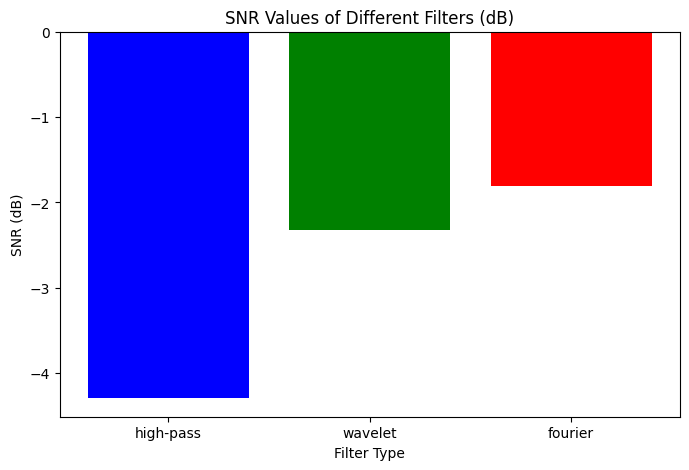

In [29]:
# Extract keys and values
labels = list(["high-pass", "wavelet", "fourier"])
values = list([lunar_output['snr'][k] for k in labels])

# Create bar graph
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'red'])

# Add title and labels
plt.title('SNR Values of Different Filters (dB)')
plt.xlabel('Filter Type')
plt.ylabel('SNR (dB)')

# Show the graph
plt.show()

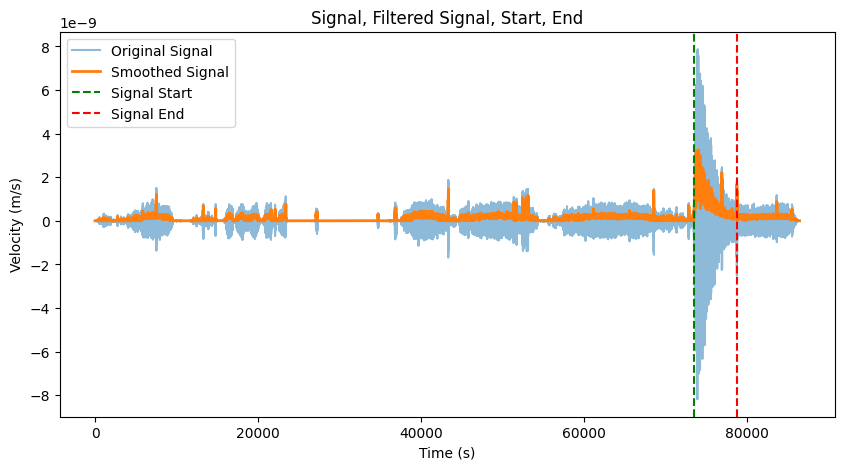

In [30]:
idx = 0
for k in lunar_output['snr'].keys():
    if k in {"smoothed"}:
        plot_signal(lunar_output['times'][idx], lunar_output['velocities']['original'][idx], k, lunar_output['velocities'][k][idx], 
                    lunar_output['signal_start_idx'][idx], lunar_output['signal_end_idx'][idx])

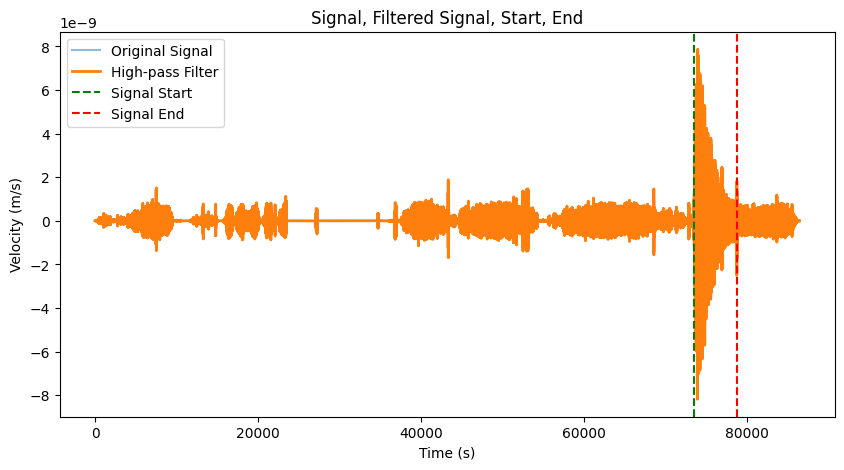

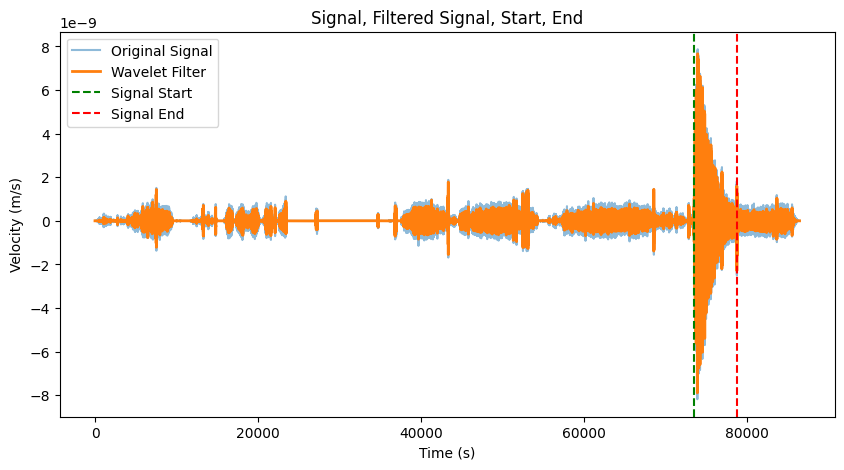

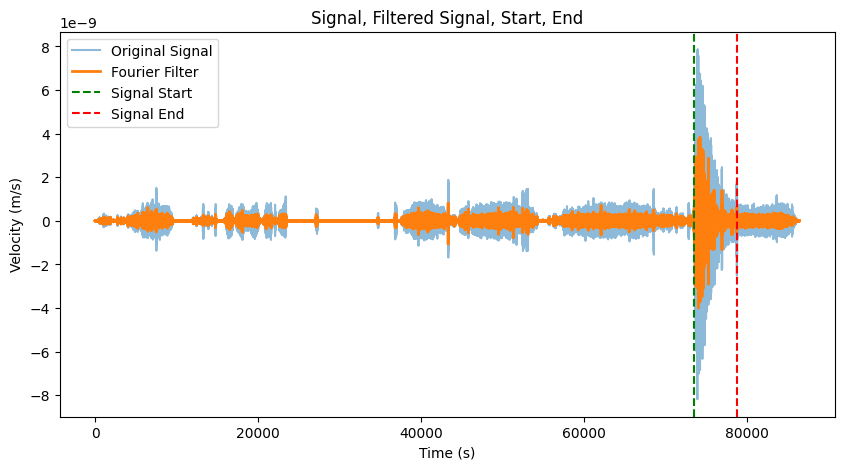

In [31]:
idx = 0
for k in lunar_output['snr'].keys():
    if k not in {"original", "smoothed"}:
        plot_signal(lunar_output['times'][idx], lunar_output['velocities']['original'][idx], k, lunar_output['velocities'][k][idx], 
                    lunar_output['signal_start_idx'][idx], lunar_output['signal_end_idx'][idx])

In [32]:
# mars params
time_label = 'rel_time(sec)'
velocity_label = 'velocity(c/s)'

# mars hyperparams
high_pass_noise_multiplier = 2.5
fourier_cutoff_freq = 1.0
velocity_rescale = 100

mars_output = calculate_snrs(mars_data, time_label, velocity_label, velocity_rescale, high_pass_noise_multiplier, fourier_cutoff_freq)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.90it/s]


In [33]:
mars_output['snr']

{'original': 1.5879047274286946,
 'smoothed': 1.0438858366231643,
 'high-pass': -1.7398213297243459,
 'wavelet': 0.48123545030952575,
 'fourier': 1.938416396595745}

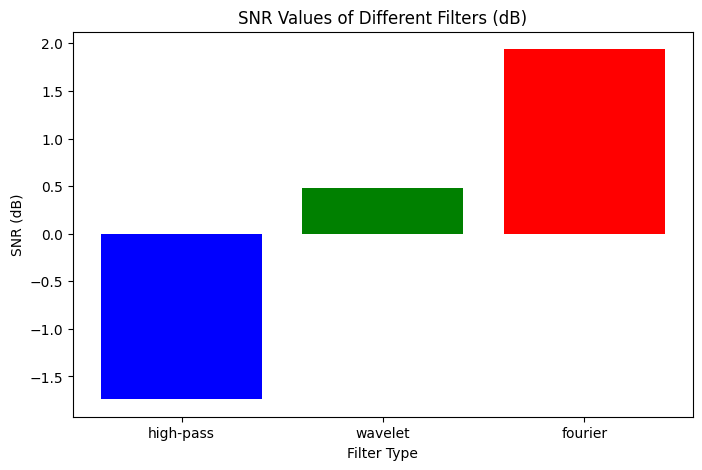

In [34]:
# Extract keys and values
labels = list(["high-pass", "wavelet", "fourier"])
values = list([mars_output['snr'][k] for k in labels])

# Create bar graph
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green', 'red'])

# Add title and labels
plt.title('SNR Values of Different Filters (dB)')
plt.xlabel('Filter Type')
plt.ylabel('SNR (dB)')

# Show the graph
plt.show()

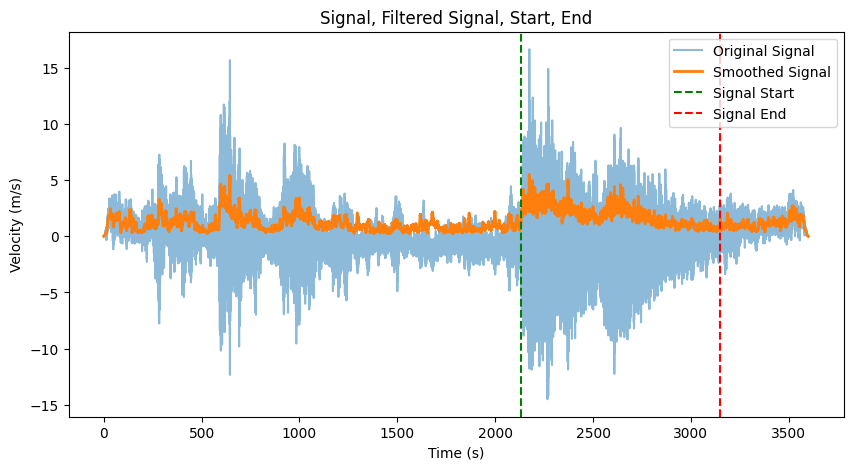

In [35]:
idx = 1
for k in mars_output['snr'].keys():
    if k in {"smoothed"}:
        plot_signal(mars_output['times'][idx], mars_output['velocities']['original'][idx], k, mars_output['velocities'][k][idx], 
                    mars_output['signal_start_idx'][idx], mars_output['signal_end_idx'][idx])

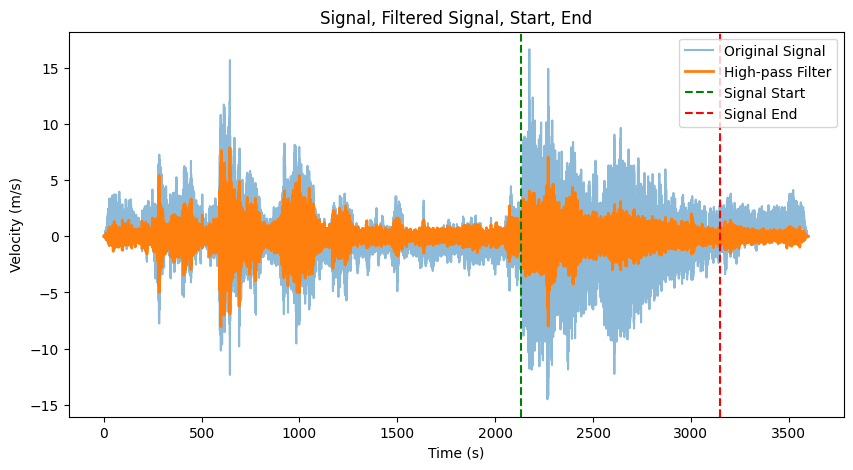

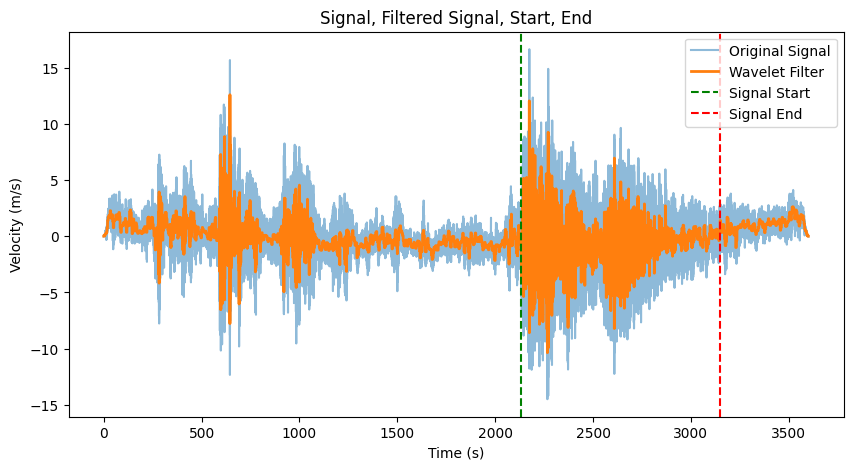

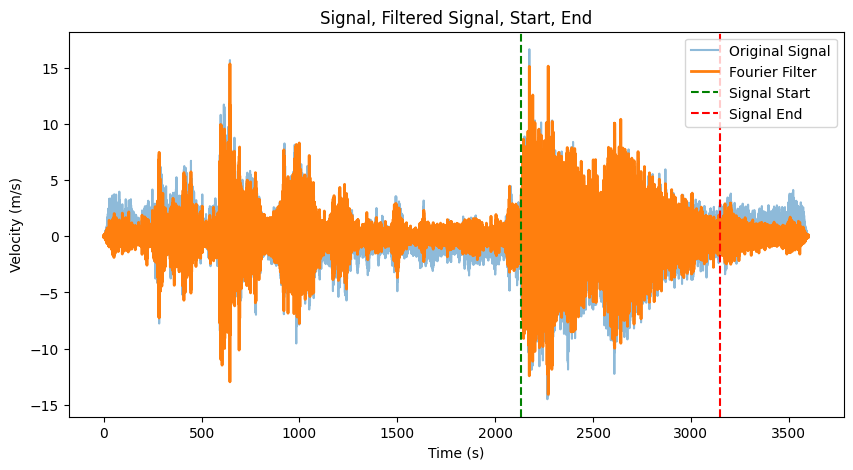

In [36]:
idx = 1
for k in mars_output['snr'].keys():
    if k not in {"original", "smoothed"}:
        plot_signal(mars_output['times'][idx], mars_output['velocities']['original'][idx], k, mars_output['velocities'][k][idx], 
                    mars_output['signal_start_idx'][idx], mars_output['signal_end_idx'][idx])

### 3. Training

#### 3.1 STA/LTA algorithm

In [37]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset

In [38]:
def calculate_sta_lta(tr_data, sampling_rate, sta_len, lta_len, trigger_on, trigger_off):
    """
    Calculate the STA/LTA ratio using Obspy's classic_sta_lta method.
    
    Parameters:
    tr_data : array-like
        The seismic velocity data.
    sampling_rate : float
        The sampling frequency of the data (in Hz).
    sta_len : float
        Length of the short-term average window (in seconds).
    lta_len : float
        Length of the long-term average window (in seconds).
    
    Returns:
    cft : array-like
        The characteristic function (STA/LTA ratio).
    """
    # Convert window lengths from seconds to samples
    sta_samples = int(sta_len * sampling_rate)
    lta_samples = int(lta_len * sampling_rate)
    
    # Calculate the STA/LTA characteristic function
    cft = classic_sta_lta(tr_data, sta_samples, lta_samples)

     # Find trigger onsets and offsets based on thresholds
    if trigger_on and trigger_off:
        onsets = trigger_onset(cft, trigger_on, trigger_off)
    
    best_onset, best_offset = None, None
    if trigger_on and trigger_off and len(onsets) > 0:
        # Find the best onset-offset pair based on the maximum STA/LTA ratio
        best_onset, best_offset = find_largest_sta_lta(cft, onsets)
    
    return cft, best_onset, best_offset

def find_largest_sta_lta(cft, onsets):
    """
    Find the onset-offset pair with the largest STA/LTA ratio.
    
    Parameters:
    cft : array-like
        The characteristic function (STA/LTA ratio).
    onsets : list of tuples
        List of onset-offset pairs, where each pair is (onset_idx, offset_idx).
    
    Returns:
    best_onset : int
        The index of the best trigger onset.
    best_offset : int
        The index of the best trigger offset.
    """
    max_ratio = -np.inf
    best_onset, best_offset = None, None

    for onset, offset in onsets:
        # Find the maximum STA/LTA ratio between the onset and offset
        max_sta_lta = np.max(cft[onset:offset])

        # If it's the largest we've seen, save this onset/offset pair
        if max_sta_lta > max_ratio:
            max_ratio = max_sta_lta
            best_onset, best_offset = onset, offset
    
    return best_onset, best_offset

def plot_sta_lta(tr_times, tr_data, cft, trigger_on=None, trigger_off=None, best_onset=None, best_offset=None):
    """
    Plot the STA/LTA characteristic function and the original data.
    
    Parameters:
    tr_times : array-like
        Array representing time values corresponding to the seismic data.
    tr_data : array-like
        The original seismic velocity data.
    cft : array-like
        The characteristic function (STA/LTA ratio).
    trigger_on : float, optional
        Threshold for triggering the onset of the P-wave.
    trigger_off : float, optional
        Threshold for triggering the end of the P-wave.
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    
    # Plot the original seismic data
    ax1.plot(tr_times, tr_data, color='black', label='Seismic Data')
    ax1.set_ylabel('Velocity (m/s)')
    ax1.set_title('Seismic Data')
    ax1.set_xlim([min(tr_times), max(tr_times)])
    ax1.legend()

    # Plot the STA/LTA characteristic function
    ax2.plot(tr_times[:len(cft)], cft, color='blue', label='STA/LTA Ratio')
    ax2.set_ylabel('STA/LTA Ratio')
    ax2.set_xlabel('Time (s)')
    ax2.set_xlim([min(tr_times), max(tr_times)])
    
    if trigger_on and trigger_off and best_onset and best_offset:        
        # Plot the best onset and offset with vertical lines
        ax2.axvline(tr_times[best_onset], color='green', linestyle='--', label='Best Trigger Onset')
        ax2.axvline(tr_times[best_offset], color='red', linestyle='--', label='Best Trigger Offset')
    
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [39]:
def rmse(actual, predicted):
    """
    Calculate Root Mean Square Error (RMSE) between actual and predicted values.
    
    Parameters:
    actual : array-like
        Array of actual values (true P-wave start times).
    predicted : array-like
        Array of predicted values (predicted P-wave start times).
    
    Returns:
    rmse : float
        The RMSE value.
    """
    # Ensure inputs are numpy arrays for efficient calculation
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    
    return float(rmse)

def calculate_rmses(data, sta_len, lta_len, trigger_on, trigger_off):
    """
    Calculates average rmse for the provided dataset for different filters
    """
    predicts = {}
    accuracies = {}

    for filter in data['snr'].keys():
        if filter == 'smoothed':
            continue

        predicts[filter] = []
        accuracies[filter] = []
        for idx in range(len(data['times'])):
            tr_data = data['velocities'][filter][idx]
            sampling_rate = data['sampling_rates'][idx]
            
            # Calculate the STA/LTA characteristic function using Obspy
            cft, best_onset, best_offset = calculate_sta_lta(tr_data, 
                                                             sampling_rate, 
                                                             sta_len, 
                                                             lta_len, 
                                                             trigger_on=trigger_on, 
                                                             trigger_off=trigger_off)

            # sometimes sta/lta couldn't detect an event
            # in that case we set up the best_offset to first times item
            if best_onset is None:
                predicts[filter].append(np.mean(data['times'][idx]))
            else:
                predicts[filter].append(data['times'][idx][best_onset])

        rmse_score = rmse(data['rel_times'], predicts[filter])
        accuracies[filter] = rmse_score

    return accuracies, predicts

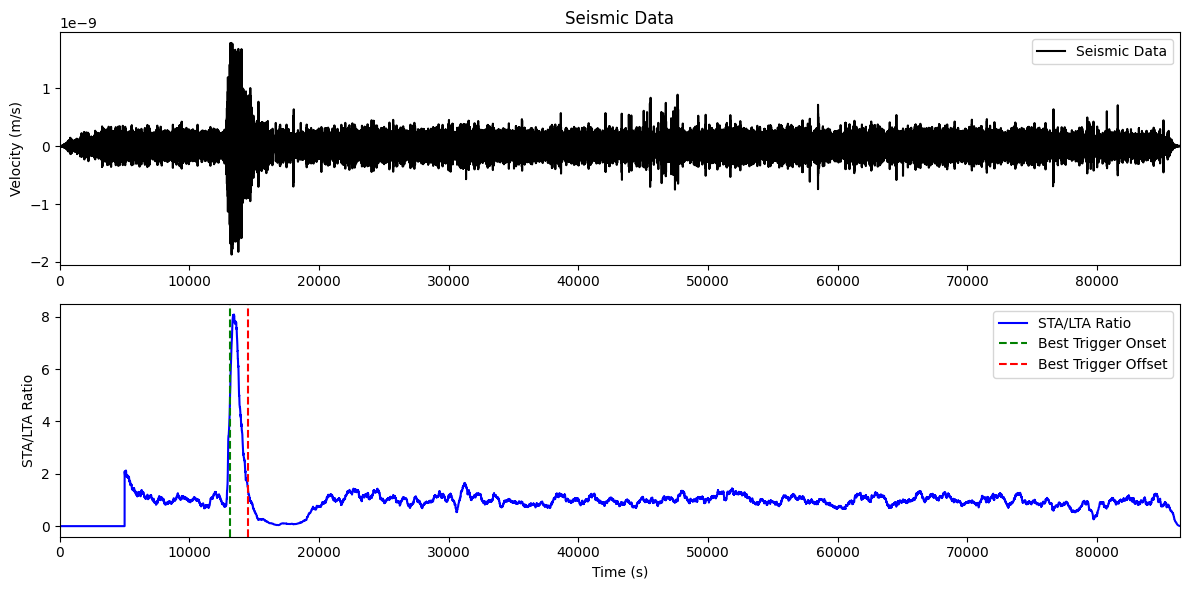

In [40]:
# Lunar data sample predict
idx = 1
sta_len = 500  # Short-term window length in seconds
lta_len = 5000  # Long-term window length in seconds
trigger_on = 4.5
trigger_off = 1.5

# Example seismic data (replace with actual velocity data)
tr_data = lunar_output['velocities']['fourier'][idx]
tr_times = lunar_output['times'][idx]
sampling_rate = lunar_output['sampling_rates'][idx]  # in Hz (adjust as needed)

# Calculate the STA/LTA characteristic function
cft, best_onset, best_offset = calculate_sta_lta(tr_data, sampling_rate, sta_len, lta_len, trigger_on=trigger_on, trigger_off=trigger_off)
# Plot the seismic data and the STA/LTA characteristic function
plot_sta_lta(tr_times, tr_data, cft, trigger_on=trigger_on, trigger_off=trigger_off, best_onset=best_onset, best_offset=best_offset)

In [41]:
accuracies, predicts = calculate_rmses(lunar_output, sta_len = sta_len, lta_len = lta_len, trigger_on=trigger_on, trigger_off=trigger_off)
accuracies

{'original': 25483.034236544507,
 'high-pass': 25753.57233848736,
 'wavelet': 26920.530924326304,
 'fourier': 21653.149897190546}

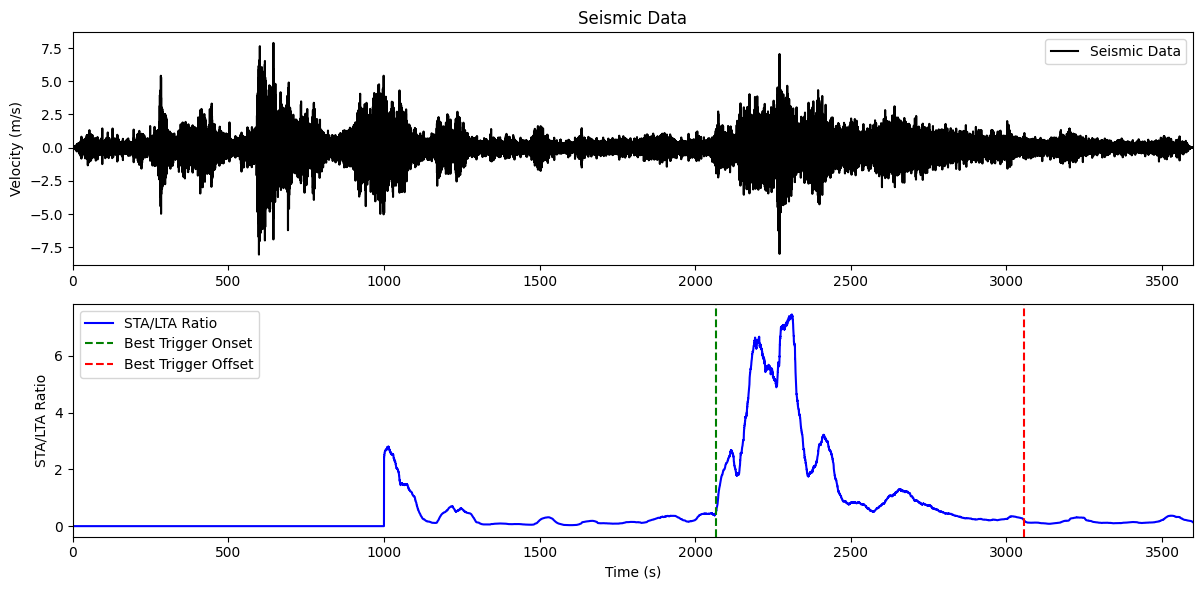

In [42]:
# Mars data predict
idx = 1
sampling_rate = mars_output['sampling_rates'][idx]  # in Hz (adjust as needed)
sta_len = 50  # Short-term window length in seconds
lta_len = 1000  # Long-term window length in seconds
trigger_on=0.5
trigger_off=0.2

# Example seismic data (replace with actual velocity data)
tr_data = mars_output['velocities']['high-pass'][idx]
tr_times = mars_output['times'][idx]

# Calculate the STA/LTA characteristic function
cft, best_onset, best_offset = calculate_sta_lta(tr_data, sampling_rate, sta_len, lta_len, trigger_on=trigger_on, trigger_off=trigger_off)

# Plot the seismic data and the STA/LTA characteristic function
plot_sta_lta(tr_times, tr_data, cft, trigger_on=trigger_on, trigger_off=trigger_off, best_onset=best_onset, best_offset=best_offset)

In [43]:
accuracies, predicts = calculate_rmses(mars_output, sta_len = sta_len, lta_len = lta_len, trigger_on=trigger_on, trigger_off=trigger_off)
accuracies

{'original': 1006.2680681607659,
 'high-pass': 854.1174692335943,
 'wavelet': 1559.7091864350868,
 'fourier': 939.36402022858}

In [44]:
from matplotlib.ticker import MaxNLocator

In [45]:
def generate_image(times, velocities, save_dir, filename="lunar_train.png", fig_size=(10, 5), with_axis=False, x="seconds", y="m/sec"):
    fig, ax = plt.subplots(figsize=fig_size)  # Set fixed figure size
    ax.plot(times, velocities, color='black')  # Black line for the signal

    if not with_axis:
        # Remove axis labels, ticks, and legends
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        ax.set_xticklabels([])  # Remove x-axis labels
        ax.set_yticklabels([])  # Remove y-axis labels
        ax.spines['top'].set_visible(False)  # Remove top border
        ax.spines['right'].set_visible(False)  # Remove right border
        ax.spines['left'].set_visible(False)  # Remove left border
        ax.spines['bottom'].set_visible(False)  # Remove bottom border
    else:
        ax.set_xlim(left=0)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=30))
        ax.tick_params(axis='both', which='major', labelsize=6)
        plt.xlabel(x)
        plt.ylabel(y)
    
    # Save the plot as an image (without showing it)
    plot_path = os.path.join(save_dir, filename)
    plt.savefig(plot_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)  # Close the figure to free up memory

In [46]:
# lunar training data

In [47]:
image_dir = "space_apps_2024_seismic_detection/data/lunar/training/images"
# os.mkdir(image_dir)

In [48]:
image_dir

'space_apps_2024_seismic_detection/data/lunar/training/images'

In [49]:
fourier_cutoff_freq = 0.9
lunar_output["training_images"] = []
for idx in tqdm(range(len(lunar_output["times"]))):
    filename = f"event_{idx}.png"
    llm_filename = f"llm_event_{idx}.png"
    
    filtered_velocities = apply_fourier_filter(lunar_output['velocities']['original'][idx], 
                                               lunar_output['sampling_rates'][idx], 
                                               cutoff_frequency=fourier_cutoff_freq)
    
    generate_image(lunar_output['times'][idx], filtered_velocities, image_dir, filename)
    generate_image(lunar_output['times'][idx], filtered_velocities, image_dir, llm_filename, with_axis=True)
    lunar_output["training_images"].append(filename)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:25<00:00,  2.98it/s]


In [50]:
# mars pretraining data

In [51]:
image_dir = "space_apps_2024_seismic_detection/data/mars/training/images"
# os.mkdir(image_dir)

In [52]:
fourier_cutoff_freq = 1.0
mars_output["training_images"] = []
for idx in tqdm(range(len(mars_output["times"]))):
    filename = f"event_{idx}.png"
    llm_filename = f"llm_event_{idx}.png"
    filtered_velocities = apply_fourier_filter(mars_output['velocities']['original'][idx], 
                                               mars_output['sampling_rates'][idx], 
                                               cutoff_frequency=fourier_cutoff_freq)
    generate_image(mars_output['times'][idx], filtered_velocities, image_dir, filename)
    generate_image(mars_output['times'][idx], filtered_velocities, image_dir, llm_filename, with_axis=True, y="c/sec")
    mars_output["training_images"].append(filename)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.26it/s]


### 4. Testing

In [53]:
from glob import glob

In [54]:
# lunar test data
lunar_output["test"] = []

In [55]:
lunar_test_directory = 'space_apps_2024_seismic_detection/data/lunar/test/data/'
test_csvs = glob(f"{lunar_test_directory}/*/*csv")
test_mseeds = glob(f"{lunar_test_directory}/*/*mseed")

In [57]:
# lunar test images
test_img_dir = "space_apps_2024_seismic_detection/data/lunar/test/images"
# os.mkdir(test_img_dir)

In [58]:
fourier_cutoff_freq = 0.9
for i, csv in enumerate(tqdm(test_csvs)):
    df = pd.read_csv(csv)
    data = {}
    data['filename'] = csv.split("/")[-1]
    data['times'] = df['time_rel(sec)'].values
    data['velocities'] = df['velocity(m/s)'].values
    mseed_file = test_mseeds[i]
    st = read(mseed_file)
    data['sampling_rate'] = st[0].stats.sampling_rate

    # generate test images
    filename = f"event_{i}.png"
    llm_filename = f"llm_event_{i}.png"
    
    filtered_velocities = apply_fourier_filter(data['velocities'], 
                                               data['sampling_rate'], 
                                               cutoff_frequency=fourier_cutoff_freq)
    
    generate_image(data['times'], filtered_velocities, test_img_dir, filename)
    generate_image(data['times'], filtered_velocities, test_img_dir, llm_filename, with_axis=True)

    data["image"] = filename
    data["llm_image"] = llm_filename
    
    lunar_output["test"].append(data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:59<00:00,  1.60it/s]


In [59]:
# mars test data

In [60]:
# lunar test data
mars_output["test"] = []

In [61]:
mars_test_directory = 'space_apps_2024_seismic_detection/data/mars/test/data/'
test_csvs = glob(f"{mars_test_directory}/*csv")
test_mseeds = glob(f"{mars_test_directory}/*mseed")

In [62]:
# mars test images
test_img_dir = "space_apps_2024_seismic_detection/data/mars/test/images"
# os.mkdir(test_img_dir)

In [63]:
fourier_cutoff_freq = 1.0
for i, csv in enumerate(tqdm(test_csvs)):
    df = pd.read_csv(csv)
    data = {}
    data['filename'] = csv.split("/")[-1]
    data['times'] = df['rel_time(sec)'].values
    data['velocities'] = df['velocity(c/s)'].values
    mseed_file = test_mseeds[i]
    st = read(mseed_file)
    data['sampling_rate'] = st[0].stats.sampling_rate

    # generate test images
    filename = f"event_{i}.png"
    llm_filename = f"llm_event_{i}.png"
    
    filtered_velocities = apply_fourier_filter(data['velocities'], 
                                               data['sampling_rate'], 
                                               cutoff_frequency=fourier_cutoff_freq)
    
    generate_image(data['times'], filtered_velocities, test_img_dir, filename)
    generate_image(data['times'], filtered_velocities, test_img_dir, llm_filename, with_axis=True)

    data["image"] = filename
    data["llm_image"] = llm_filename
    
    mars_output["test"].append(data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.64it/s]


#### 4.1 Predict using STA/LTA

In [64]:
# lunar hyperparams
sta_len = 500
lta_len = 5000
trigger_on = 4.5
trigger_off = 1.5
high_pass_noise_multiplier = 5
fourier_cutoff_freq = 0.9
velocity_rescale = 1.0
predictions = []
for d in tqdm(lunar_output['test']):
    # filter the signal
    filtered_velocities = apply_fourier_filter(d["velocities"], d["sampling_rate"], cutoff_frequency=fourier_cutoff_freq)
    _, best_onset, _ = calculate_sta_lta(filtered_velocities, 
                                         d["sampling_rate"], 
                                         sta_len, 
                                         lta_len, 
                                         trigger_on=trigger_on,
                                         trigger_off=trigger_off)

    predictions.append({
        "filename": d["filename"],
        "time_rel(sec)": float(best_onset) if best_onset else float(np.mean(d["times"])) # in case if sta/lta failed
    })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:07<00:00, 13.16it/s]


In [65]:
pd.DataFrame(predictions).to_csv('space_apps_2024_seismic_detection/data/lunar/test/sta_lta_predictions.csv', index=False)

In [66]:
# mars hyperparams
sta_len = 50
lta_len = 1000
trigger_on=0.5
trigger_off=0.2
high_pass_noise_multiplier = 2.5
fourier_cutoff_freq = 1.0
velocity_rescale = 100

predictions = []
for d in tqdm(mars_output['test']):
    # filter the signal
    filtered_velocities = apply_fourier_filter(d["velocities"], d["sampling_rate"], cutoff_frequency=fourier_cutoff_freq)
    _, best_onset, _ = calculate_sta_lta(filtered_velocities, 
                                         d["sampling_rate"], 
                                         sta_len, 
                                         lta_len, 
                                         trigger_on=trigger_on, 
                                         trigger_off=trigger_off)

    predictions.append({
        "filename": d["filename"],
        "time_rel(sec)": float(best_onset) if best_onset else float(np.mean(d["times"])) # in case if sta/lta failed
    })

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 470.49it/s]


In [67]:
pd.DataFrame(predictions).to_csv('space_apps_2024_seismic_detection/data/mars/test/sta_lta_predictions.csv', index=False)

#### 4.2 LLM-based

In [68]:
from langchain_openai import AzureChatOpenAI
from langchain.chains import LLMChain

In [69]:
import getpass
import os

if "AZURE_OPENAI_API_KEY" not in os.environ:
    os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass(
        "Enter your AzureOpenAI API key: "
    )
if "AZURE_OPENAI_ENDPOINT" not in os.environ:
    os.environ["AZURE_OPENAI_ENDPOINT"] = getpass.getpass(
        "Enter your AzureOpenAI Endpoint: "
    )

Enter your AzureOpenAI API key:  ········
Enter your AzureOpenAI Endpoint:  ········


In [74]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment="gpt-4o",
    model="gpt-4o",
    api_version="2024-02-15-preview",
    api_key=os.environ["AZURE_OPENAI_API_KEY"]
)

In [75]:
from langchain_core.messages import HumanMessage

In [76]:
import re
import base64
from mimetypes import guess_type

def local_image_to_data_url(image_path):
    """
    Read a local image, encode it in base64, and return the base64 string.
    
    Parameters:
    image_path : str
        The path to the local image file.
    
    Returns:
    str
        Base64 encoded string of the image.
    """
    # Open the image file in binary mode
    with open(image_path, "rb") as image_file:
        # Read the file content and encode it in base64
        base64_encoded_image = base64.b64encode(image_file.read()).decode("utf-8")
    
    return base64_encoded_image

def predict_start(image_url):
    message = HumanMessage(
        content=[
            {"type": "text", "text": "Based on the provided image return a number of seconds where P-wave starts. Return number that is at maximum close to the start of the P-wave. Always return the numeric value."},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{data_url}"},
            },
        ],
    )
    response = llm.invoke([message])
    
    processed = response.content.replace(',', '')
    pattern = r'\d+(?:\.\d+)?'
    numbers = re.findall(pattern, processed)

    if len(numbers):
        return float(numbers[0])

In [77]:
# lunar train predict
predicts = []
for idx in tqdm(range(len(lunar_output["training_images"]))):
    image_path = f'space_apps_2024_seismic_detection/data/lunar/training/images/llm_{lunar_output["training_images"][idx]}'
    data_url = local_image_to_data_url(image_path)
    rel_time = predict_start(data_url)
    predicts.append(rel_time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [01:11<00:00,  1.05it/s]


In [78]:
print(f"RMSE: {rmse(predicts, lunar_output['rel_times'])} secs")
print(f"MAE: {np.mean(np.abs(predicts - np.array(lunar_output['rel_times'])))} secs")

RMSE: 14663.190194042587 secs
MAE: 7401.866666666667 secs


In [79]:
# lunar test predict
preds = []
predictions = []
for idx in tqdm(range(len(lunar_output["test"]))):
    filename = lunar_output["test"][idx]["llm_image"]
    image_path = f'space_apps_2024_seismic_detection/data/lunar/test/images/{filename}'
    data_url = local_image_to_data_url(image_path)
    rel_time = predict_start(data_url)
    preds.append(rel_time)
    predictions.append({
        'filename': lunar_output["test"][idx]["filename"],
        'time_rel(sec)': rel_time
    })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [01:53<00:00,  1.18s/it]


In [80]:
pd.DataFrame(predictions).to_csv('space_apps_2024_seismic_detection/data/lunar/test/llm_predictions.csv', index=False)

In [81]:
# mars train predict
predicts = []
for idx in tqdm(range(len(mars_output["training_images"]))):
    image_path = f'space_apps_2024_seismic_detection/data/mars/training/images/llm_{mars_output["training_images"][idx]}'
    data_url = local_image_to_data_url(image_path)
    rel_time = predict_start(data_url)
    predicts.append(rel_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


In [82]:
print(f"RMSE: {rmse(predicts, mars_output['rel_times'])} secs")
print(f"MAE: {np.mean(np.abs(predicts - np.array(mars_output['rel_times'])))} secs")

RMSE: 1117.5350106372507 secs
MAE: 808.5 secs


In [83]:
# mars test predict
predictions = []
for idx in tqdm(range(len(mars_output["test"]))):
    filename = mars_output["test"][idx]["llm_image"]
    image_path = f'space_apps_2024_seismic_detection/data/lunar/test/images/{filename}'
    data_url = local_image_to_data_url(image_path)
    rel_time = predict_start(data_url)
    predictions.append({
        'filename': mars_output["test"][idx]["filename"],
        'time_rel(sec)': rel_time
    })

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.09it/s]


In [84]:
pd.DataFrame(predictions).to_csv('space_apps_2024_seismic_detection/data/mars/test/llm_predictions.csv', index=False)

### 6. Discussion

Our objective was to detect the P-wave start in seismic data from the Moon and Mars. We began by implementing a Signal-to-Noise Ratio (SNR) function to assess the effectiveness of various filters, including high-pass, wavelet, and Fourier filtering. The SNR required knowledge of the signal's start (available in the training data), its end (which we approximated), and the noise level. For signal end detection, we utilized the noise energy prior to the signal start and applied a smoothing technique to handle negative signals by mirroring them positively. This approach enabled us to identify an approximate signal end and calculate the SNR effectively. After evaluating the three filters, we found that Fourier filtering was the most effective for both lunar and Martian seismic events.

While we initially implemented the classical STA/LTA algorithm for event detection, we encountered some challenges with tuning. However, this opened the door for exploration, leading us to leverage state-of-the-art Large Language Models (LLMs) like GPT-4o. The multimodal capabilities of these advanced models allowed us to successfully identify the start of seismic signals without the need for additional training. This highlights the exciting potential of combining traditional signal processing methods with cutting-edge AI techniques, paving the way for more accurate and efficient seismic detection in future planetary explorations.